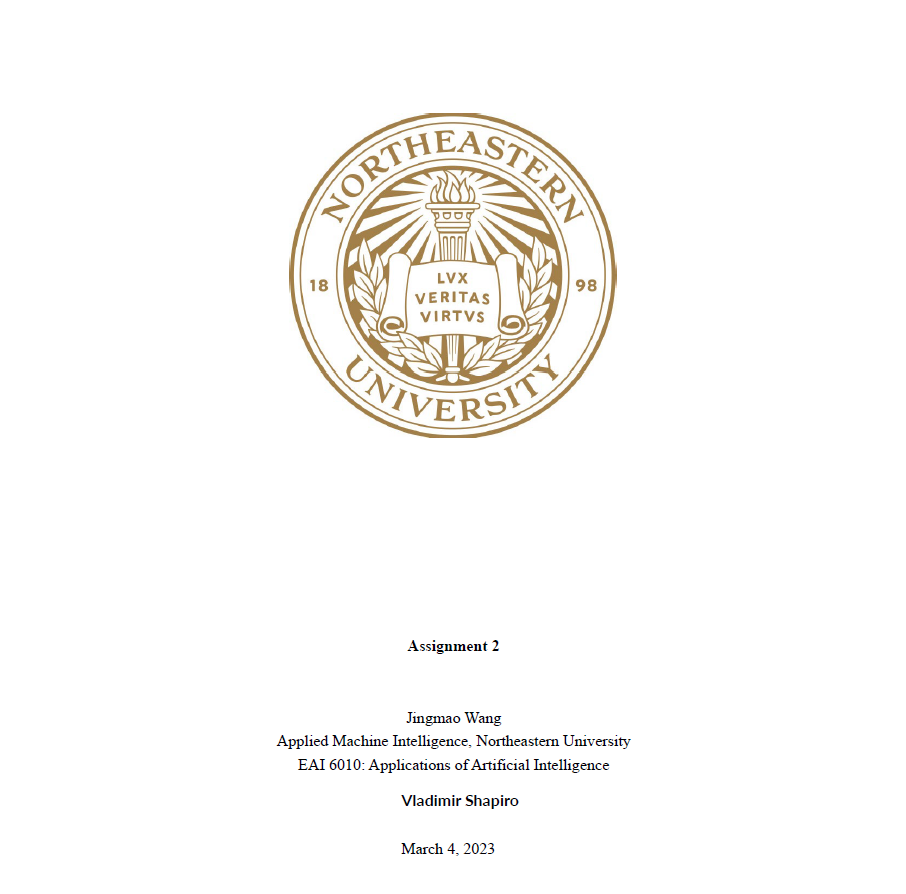

## Introduction
This assignment we will use Neural artistic style transfer to create a stylized image X from A content image C and style image S.

## Analysis
First, we need to install TensorFlow and import some libraries that we need.

In [ ]:
pip install tensorflow  #install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import functools  #import some libraries 
import os
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)     #check the version of tensorflow
print("TF-Hub version: ", hub.__version__)   #check the version of tensorflow_hub
print("Eager mode enabled: ", tf.executing_eagerly()) #check whether Eager mode is currently enabled
print("GPU available: ", tf.test.is_gpu_available()) # check whether we use GPU to accelerate

TF Version:  2.11.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  True


Next,define several functions for loading and visualizing images.

In [ ]:
def crop_center(image):  # This function returns a cropped square image by finding the smaller dimension of the image and cropping the larger dimension in half.
  shape = image.shape   # get the original shape of image
  new_shape = min(shape[1], shape[2])    #finding the smaller dimension between the width and height of the image.
  offset_y = max(shape[1] - shape[2], 0) // 2  #calculates the amount of offset needed to crop the larger dimension in half. offset_y for the vertical offset.
  offset_x = max(shape[2] - shape[1], 0) // 2  #offset_x for the horizontal offset.
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape) # Use the parameters above to crop the original shape into a new one and save it to image
  return image   # return the cropped image

@functools.lru_cache(maxsize=None)   #This is a decorator that caches the results of the function. 'maxsize = None' means the size of cache without limit
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  #This is a function that loads and preprocesses an image from a URL. 
  #This function takes an image_url, image size (defaulting to 256x256), 'preserve_aspect_ratio=True' means preserve the aspect ratio of the image when resizing.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url) #full path of the downloaded file.
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...] #reads the image from the file,converts it to a NumPy array offloat32 and adds a batch dimension to the array.
  if img.max() > 1.0: #checks if the maximum pixel value in the image is greater than 1.0.
    img = img / 255. # if so, normalizes the image to the range [0, 1] by dividing by 255
  if len(img.shape) == 3: # if the image is grayscale, converts it to a 3-channel RGB image by stacking the grayscale image three times along the last axis.
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img) # use crop_center function which we have defined to crop the image.
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True) #resizes the image,'preserve_aspect_ratio=True' means resizing to the size that fits within the specified size.
  return img  # return img

def show_n(images, titles=('',)): # This function is used to display images, it takes in two parameters.
  n = len(images) #calculates the number of images in the list
  image_sizes = [image.shape[1] for image in images] #create a list of the width of each image
  w = (image_sizes[0] * 6) // 320 #calculates the width of each subplot. The '//' performs integer division,and 6 and 320 are constants used to determine the scaling factor.
  plt.figure(figsize=(w  * n, w)) # create a new figure
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes) #creates a grid of subplots
  for i in range(n): # This loop iterates over each image in the list and displays it in a subplot. 
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal') #display the image
    plt.axis('off') # remove the axes labels
    plt.title(titles[i] if len(titles) > i else '') #display the title
  plt.show() # plot

def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True): # load the picture
  img = image_bytes# import a new image
  if img.max() > 1.0: # checks whether the maximum value in img is greater than 1.0
    img = img / 255. # if so, divide by 255 to normalize.
  if len(img.shape) == 3: # check whether the input image_bytes is a 3D array
    img = tf.stack([img, img, img], axis=-1) # stacks the array along the final axis to create a 4D array with three channels.
  img = crop_center(img) # crop the image to a square
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True) # resizes the image
  return img # return img

Import fast arbitrary image style transfer module from TF-Hub

In [ ]:
# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2' #module website
hub_module = hub.load(hub_handle)# load module

First, try the original (from the Tensorflow source) files:

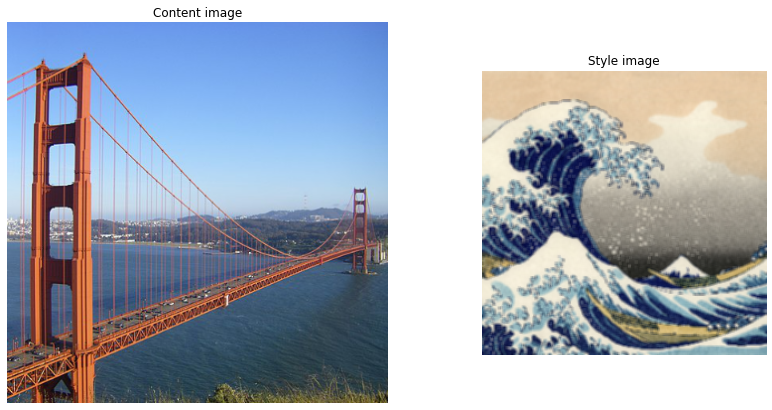

              Figure 1: Content image                                 Figure 2: Style image


In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size) # use load_image funcation to load content image 
style_image = load_image(style_image_url, style_img_size) # load style_image
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')#downscale the style image.
show_n([content_image, style_image], ['Content image', 'Style image'])# show images
print('             \033[1m Figure 1: Content image                                 \033[1mFigure 2: Style image')

Figure 1 is the content image, Figure 2 is the Style image. Next, we will demonstrate image stylization.



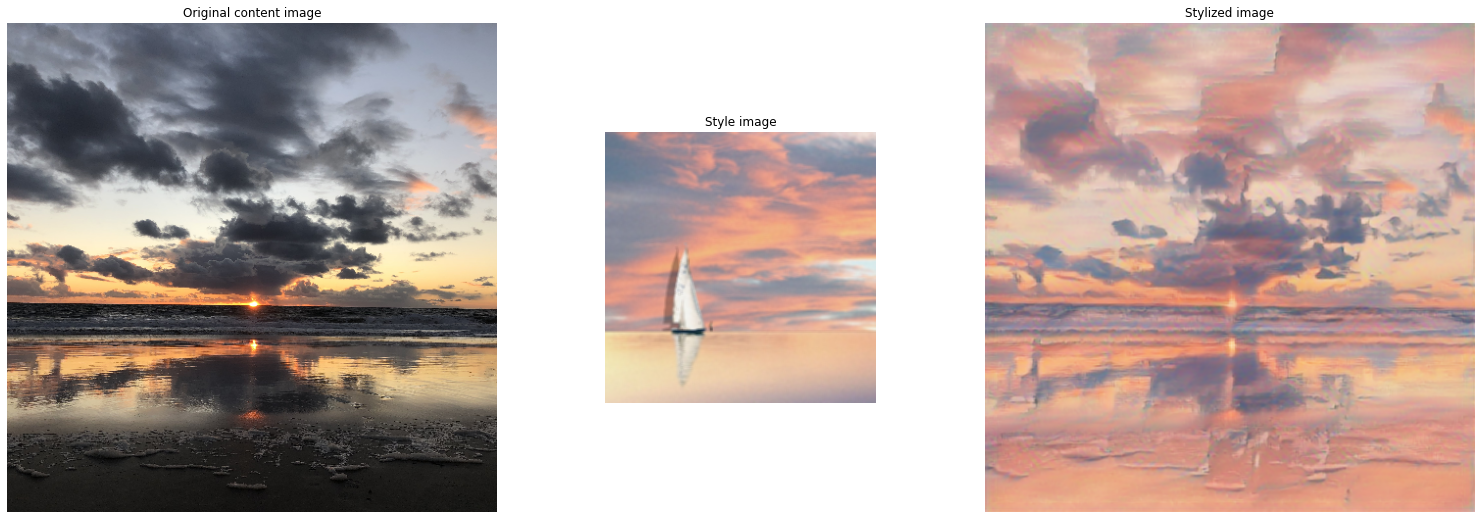

              Figure 1: Content image                                            Figure 2: Style image                                                Figure 3: Stylized image


In [ ]:
outputs = hub_module(content_image, style_image) # use TF-Hub module 
stylized_image = outputs[0] # save to stylized_image
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))# Stylize content image with given style image.
stylized_image = outputs[0]  # save
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image']) # Visualize input images and the generated stylized image.
print('             \033[1m Figure 1: Content image                                            \033[1mFigure 2: Style image                                                \033[1mFigure 3: Stylized image')

Figure 1 is the original image, Figure 2 is the style image, Figure 3 is the stylized image by Figure 1 and Figure 2. 

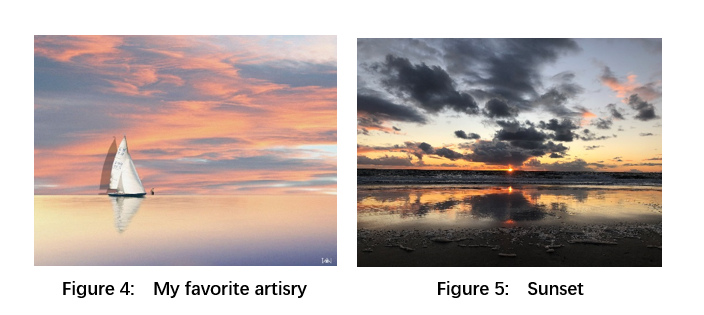

  Figure 4 is my favorite style, Figure 5 is California Sunset. Finally we will select some of our favorite images for stylized conversion 

Browse to the style file  to be uploaded


Saving 微信图片_20230304163549.jpg to 微信图片_20230304163549 (11).jpg
User uploaded file 微信图片_20230304163549.jpg with length 158029 fbytes
Browse to the content file to be uploaded


Saving 微信图片_20230304163606.jpg to 微信图片_20230304163606 (11).jpg
User uploaded content file 微信图片_20230304163606.jpg with length 5080930 fbytes


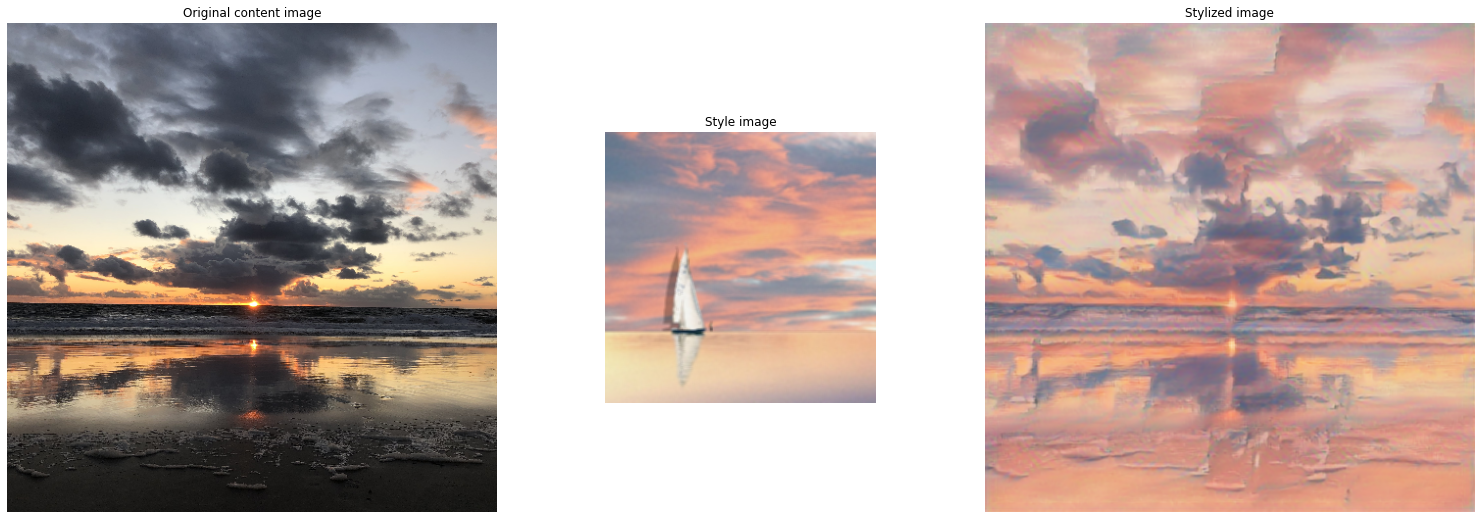

                       Figure 5: Sunset                                           Figure 4: My favorite artisry                                 Figure 6: Stylized image


In [ ]:
from google.colab import files # import library
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload() # save upload file as style image
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                            length=len(style_uploaded[fn])))#print name and length.
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]# resized dimensions and converted to float32.

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()   # save upload file as style image
for fn in content_uploaded.keys():    
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                            length=len(content_uploaded[fn])))#print name and length.
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]# resized dimensions and converted to float32

# @title Load example images  { display-mode: "form" }
output_image_size = 500  # @param {type:"integer"}   # output size

content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size) # load image and save
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')#downscale the style image
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image)) # create outputs
stylized_image = outputs[0] # save stylized_image

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])# show
print('                      \033[1m Figure 5: Sunset                                           \033[1mFigure 4: My favorite artisry                                 \033[1mFigure 6: Stylized image')

Figure 5 is original content image, Figure 4 is the style image and  Figure 6 is the stylized image by Figure 4 and Figure 5.

##Conclusion
First, we define some image loading and visualization functions, then we import a fast arbitrary image style transfer module from the TF-Hub module to make an example. Finally, uploading our own style image and content image to generate a stylized image.


##References

Ghiasi, G., Lee, H., Kudlur, M., Dumoulin, V., &amp; Shlens, J. (2017, August 24). Exploring the structure of a real-time, arbitrary neural artistic stylization network. arXiv.org. Retrieved March 4, 2023, from https://arxiv.org/abs/1705.06830 